# Real Estate Data Analysis

[Data Source](https://drive.google.com/file/d/1hDWtr00dFzbeW4u4KEVPVUivu8ZksYKm/view)

**Objective**: Exploratory analysis of the real estate dataset and train a linear regression model to estimate house price of unit area. Features combination of *house age*, *distance to the nearest MRT station*, and *number of convenience stores*.


In [621]:
## import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')


## Preprocessing

### Load data

In [622]:
df=pd.read_csv('data/real_estate.csv')
print('shape of the dataset:',df.shape)
df.head()

shape of the dataset: (414, 8)


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [623]:
# rename columns: Replace 'space' with '_'
df.columns=df.columns.str.replace(' ','_')

In [624]:
# drop the 'No' columns, it is a duplicate of 'index' 
df=df.drop(columns='No')
df.sample(5)

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
81,2013.000,30.8,377.7956,6,24.96427,121.53964,36.8
182,2013.500,13.5,2147.3760,3,24.96299,121.51284,23.6
288,2013.583,16.6,323.6912,6,24.97841,121.54280,51.0
248,2013.000,19.0,1009.2350,0,24.96357,121.54951,22.3
2,2013.583,13.3,561.9845,5,24.98746,121.54391,47.3


In [625]:
# check datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1_transaction_date                     414 non-null    float64
 1   X2_house_age                            414 non-null    float64
 2   X3_distance_to_the_nearest_MRT_station  414 non-null    float64
 3   X4_number_of_convenience_stores         414 non-null    int64  
 4   X5_latitude                             414 non-null    float64
 5   X6_longitude                            414 non-null    float64
 6   Y_house_price_of_unit_area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


### Missing & Duplicated values

In [626]:
# Missing values
print('Missing values per column:\n',df.isnull().sum(axis=0))
# Duplicate values
print('\n Duplicates\n',df.duplicated().sum())

Missing values per column:
 X1_transaction_date                       0
X2_house_age                              0
X3_distance_to_the_nearest_MRT_station    0
X4_number_of_convenience_stores           0
X5_latitude                               0
X6_longitude                              0
Y_house_price_of_unit_area                0
dtype: int64

 Duplicates
 0


The data does not have any missing value or duplicated values

### Outliers

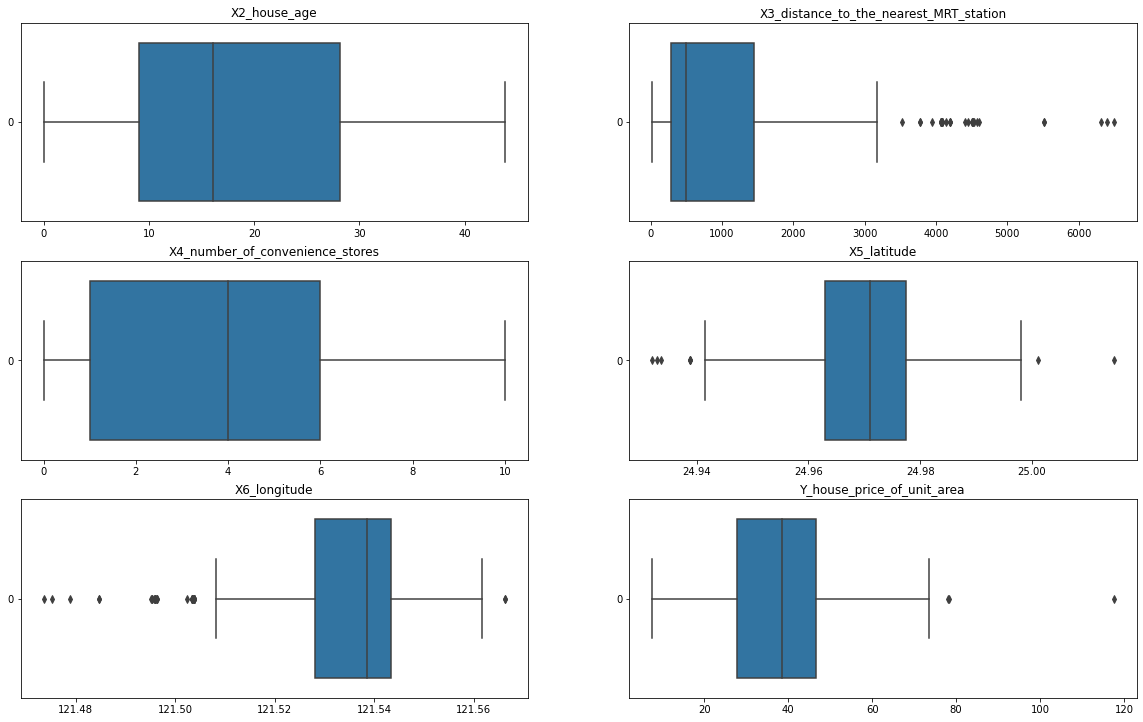

In [627]:
# plot a box plot for all numerical values 
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=3, ncols=2,figsize=(20,5))

# Define arrays to plot on 
ax_array = ax_array.flatten()

# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.boxplot(data=df.iloc[:,i+1], orient="h", ax = ax)
  # Set the title as the variable name
  ax.set_title(df.columns[i+1])
  fig.subplots_adjust(top=2)

plt.show()

Column *X3_distance_to_the_nearest_MRT_station* has outliers.

In [628]:
# Identify the outliers using Tukey Rule to determine whether ro remove or not

cols = ['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(df,i)
  print("Column ",i,"Outliers: ",outliers_Tukey)

Column  X2_house_age Outliers:  []
Column  X3_distance_to_the_nearest_MRT_station Outliers:  [8, 30, 35, 40, 41, 48, 49, 58, 73, 87, 89, 116, 117, 148, 154, 155, 162, 170, 176, 180, 183, 187, 189, 194, 226, 228, 231, 232, 249, 255, 298, 307, 320, 329, 331, 344, 347, 382, 384, 394, 409]
Column  X4_number_of_convenience_stores Outliers:  []


We will keep the outliers. Given that the size of the outliers is significant in comparison to the size of our dataset. Removing the outliers will cause a  statistical significance on our data.

### Scaling


#### Density plots

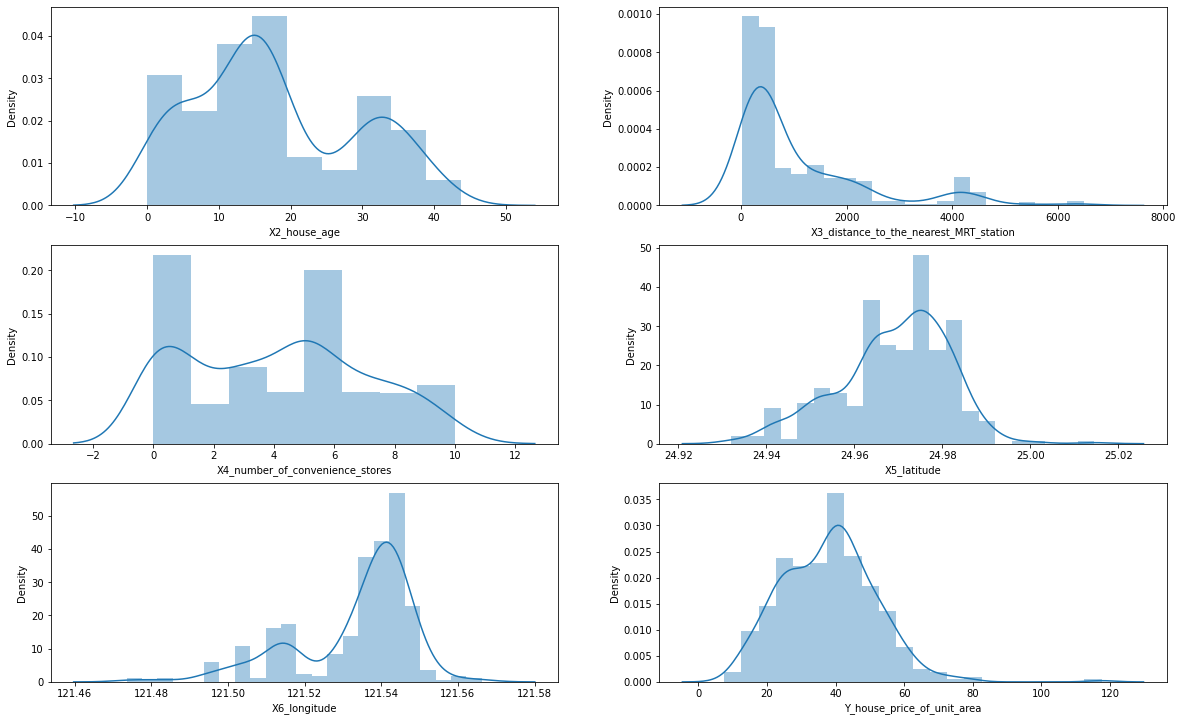

In [629]:
# plot a density plot for all numerical values 
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=3, ncols=2,figsize=(20,5))

# Define arrays to plot on 
ax_array = ax_array.flatten()

# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.distplot(df.iloc[:,i+1], ax=ax)
  fig.subplots_adjust(top=2)

plt.show()

#### Standard Scaler

In [630]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features=['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores','X5_latitude','X6_longitude']
df_scaled=df[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores','X5_latitude','X6_longitude']]
df_scaled[features] = scaler.fit_transform(df_scaled.values)
df_scaled.head(5)

,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude
0,1.255628,-0.792495,2.007407,1.125430,0.448762
1,0.157086,-0.616612,1.667503,0.912444,0.401139
2,-0.387791,-0.414015,0.307885,1.486860,0.688183
3,-0.387791,-0.414015,0.307885,1.486860,0.688183
4,-1.117223,-0.549997,0.307885,0.834188,0.592937


Our dataset has columns with different units.To be sure that the model treats both variables equally we have to scale the data by transformation of data into z-scores (by subtracting the feature mean and divding by the feature standard deviation). It's purpose is to ensure all features are on a common scale without distorting the relative differences between the instance values.

### Transform

In [631]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson')
df_scaled[features] = scaler.fit_transform(df_scaled.values)
df_scaled.head(5)

,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude
0,1.215934,-1.360505,1.908441,1.187649,0.304736
1,0.282924,-0.757326,1.606985,0.926901,0.232235
2,-0.291916,-0.188349,0.346429,1.646061,0.699774
3,-0.291916,-0.188349,0.346429,1.646061,0.699774
4,-1.194272,-0.555906,0.346429,0.832983,0.536557


**Justification**: Some Machine Learning models, like Linear and Logistic regression, assume that the variables follow a normal distribution. Our features  does not follow a normal distribtution. By applying some transformations to these features, we can ensure that this can increase the performance of our models.

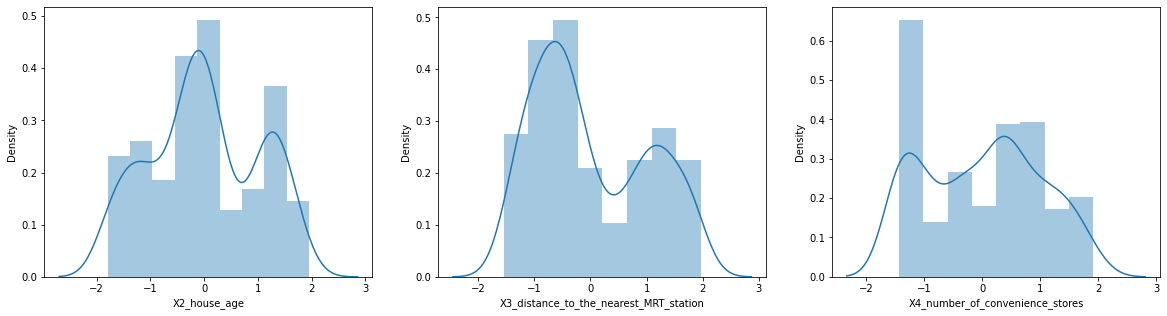

In [632]:
# Distribution after transfrom and scaling
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=1, ncols=3,figsize=(20,2))
# Define arrays to plot on 
ax_array = ax_array.flatten()
# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.distplot(df_scaled.iloc[:,i], ax=ax)
  fig.subplots_adjust(top=2)

plt.show()

### Columns that contain discrete variables, convert them to dummy variables

In [633]:
df.sample(5)

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
391,2013.583,6.2,1939.7490,1,24.95155,121.55387,31.3
299,2013.167,33.2,121.7262,10,24.98178,121.54059,46.1
62,2012.917,17.2,2175.8770,3,24.96303,121.51254,27.7
329,2013.000,13.6,4197.3490,0,24.93885,121.50383,19.2
278,2012.750,0.0,208.3905,6,24.95618,121.53844,44.0


Column *X4_number_of_convenience_stores* contain discrete variables

In [634]:
# converting discrete variables to dummy
pd.get_dummies(df, columns=['X4_number_of_convenience_stores']).head()

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X5_latitude,X6_longitude,Y_house_price_of_unit_area,X4_number_of_convenience_stores_0,X4_number_of_convenience_stores_1,X4_number_of_convenience_stores_2,X4_number_of_convenience_stores_3,X4_number_of_convenience_stores_4,X4_number_of_convenience_stores_5,X4_number_of_convenience_stores_6,X4_number_of_convenience_stores_7,X4_number_of_convenience_stores_8,X4_number_of_convenience_stores_9,X4_number_of_convenience_stores_10
0,2012.917,32.0,84.87882,24.98298,121.54024,37.9,0,0,0,0,0,0,0,0,0,0,1
1,2012.917,19.5,306.59470,24.98034,121.53951,42.2,0,0,0,0,0,0,0,0,0,1,0
2,2013.583,13.3,561.98450,24.98746,121.54391,47.3,0,0,0,0,0,1,0,0,0,0,0
3,2013.500,13.3,561.98450,24.98746,121.54391,54.8,0,0,0,0,0,1,0,0,0,0,0
4,2012.833,5.0,390.56840,24.97937,121.54245,43.1,0,0,0,0,0,1,0,0,0,0,0


## Linear regression model

### Model

In [635]:
# modeling libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


In [636]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']] #predictors

# Split data 80%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 331 rows
Test Set: 83 rows

 Model score:
MSE: 48.915624386313155
RMSE: 6.993970573738007
R2: 0.718388587452236
Adjusted_R2: 0.7158049965114308


**Evaluation explanation**:
- Model has an r2 score of 0.718. This is the amount of the variation in the output dependent attribute which is predictable from the input independent variable(s),  to check how well-observed results are reproduced by the model, depending on the ratio of total deviation of results described by the model.
- Model has an adjusted r2 score of 0.715.This implies how better model is fitted to the data points 
- The model has a RMSE of 6.99 .  This tells the average distance between the predicted values from the model and the actual values in the dataset.

### Playing with predictors to check if it improves the model accuracy.

Remove the *X4_number_of_convenience_stores* column

In [637]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
# Remove one of the predictor
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station']] #predictors

# Split data 80%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 331 rows
Test Set: 83 rows

 Model score:
MSE: 51.56284729346574
RMSE: 7.180727490544794
R2: 0.7031482998843106
Adjusted_R2: 0.7013382285421418


Removal of one predictor slightly reduces the rating of the model

Adding *X5_latitude* and *X6_latitude* to the predictors

In [638]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores','X5_latitude','X6_longitude']] #predictors

# Split data 80%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 331 rows
Test Set: 83 rows

 Model score:
MSE: 45.21653022110644
RMSE: 6.724323774262096
R2: 0.7396845873721006
Adjusted_R2: 0.7356797348701329


On adding more predictors, this improves the model performance

### Model with different set of parameters.

1. Adjust the test and train size with ratio of 90% to 10%

In [639]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']] #predictors

# Split data 90%-10% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 372 rows
Test Set: 42 rows

 Model score:
MSE: 41.398153041559674
RMSE: 6.434139650455193
R2: 0.6800921862301448
Adjusted_R2: 0.6774842420961513


Adjusting the test size reduces the model score

2. Adjust the train and test size to higher ratio of 70% to 30% and including a random state of 42

In [640]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']] #predictors

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 289 rows
Test Set: 125 rows

 Model score:
MSE: 65.01141438227236
RMSE: 8.062965607161695
R2: 0.6112341502572507
Adjusted_R2: 0.6071418781546954


3.  Adjusr the Model parameter to [fit_intercept=True, normalize=False, copy_X=True]

In [641]:
# split test and train data
y=df['Y_house_price_of_unit_area'] # label
X=df_scaled[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']] #predictors

# Split data 80%-20% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))
# Fit a linear regression model on the training set
model = LinearRegression(fit_intercept=False, normalize=False, copy_X=False).fit(X_train, y_train)
# test model
predictions = model.predict(X_test)
# evaluate model score
print('\n Model score:')
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted_R2:", adj_r2)


Training Set: 331 rows
Test Set: 83 rows

 Model score:
MSE: 1467.5708946575508
RMSE: 38.30888793292688
R2: -7.448930537910865
Adjusted_R2: -7.526443662111882


## **Summary**
I believe that my BEST model is good because it is an accurate representation of the data:

1. The equation has a co-efficient of determination (R2) greater than 0.7, meaning that it’s predictive or explanatory power is greater than 70%. This means the model is performing well.

2. The data used to create the model has be preprocessed, scaled and transformed , so there are no missing values or outliers, which can make a difference when trying to predict future behavior.

3. A linear regression is used at each step of the model building process to ensure that a relationship exists between each independent and dependent variable in order to determine whether or not one variable may have an impact on another.